In [1]:
import os
import zipfile
import datetime
from datetime import datetime, date

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns 

from sklearn. impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import cross_val_score, train_test_split
import sklearn.metrics as metrics

pd.set_option('display.max_columns', False)

sns.set()
%matplotlib inline

In [2]:
DATASET_PATH = "./aviakompaniya.zip"

def fetch_flight_price_data(dataset_path = DATASET_PATH):
    with zipfile.ZipFile(dataset_path, 'r') as dataset_zip:
        dataset_zip.extractall(path="./")

In [3]:
fetch_flight_price_data()

In [4]:
def load_dataset(dataset_path, file):
    csv_path = os.path.join(dataset_path, file)
    return pd.read_csv(csv_path)

In [5]:
train_data = load_dataset("./", "train_dataset.csv")
train_data.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,Male,disloyal Customer,33,Business travel,Eco,571,2,3,2,4,4,2,4,4,3,1,3,4,3,4,10,3.0,0
1,2,Female,Loyal Customer,49,Business travel,Business,1431,4,1,4,4,3,5,4,5,5,5,5,3,5,3,0,0.0,1
2,3,Female,Loyal Customer,43,Business travel,Eco,867,1,4,4,4,4,4,3,1,1,1,1,1,1,2,0,18.0,0
3,4,Female,Loyal Customer,27,Business travel,Business,1550,3,3,3,3,2,2,2,2,4,4,5,5,4,2,0,0.0,1
4,5,Male,Loyal Customer,11,Personal Travel,Eco,526,3,4,3,2,4,3,4,4,5,2,5,3,5,4,0,10.0,0


In [6]:
test_data = load_dataset("./", "test_dataset.csv")
test_data.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,1,Female,Loyal Customer,25,Personal Travel,Eco,2704,2,2,2,3,2,3,5,2,4,4,3,5,1,5,152,191.0
1,2,Female,Loyal Customer,49,Business travel,Business,1623,1,1,1,1,3,4,4,2,2,2,2,4,2,3,60,52.0
2,3,Male,Loyal Customer,51,Business travel,Business,338,4,4,4,4,2,5,5,5,5,5,5,4,5,4,0,0.0
3,4,Male,Loyal Customer,34,Business travel,Eco Plus,95,0,0,0,3,5,0,1,5,4,4,1,3,3,5,0,0.0
4,5,Male,Loyal Customer,34,Personal Travel,Eco,602,4,4,4,3,4,5,5,5,4,5,4,5,5,5,130,140.0


In [7]:
train_data.shape

(10000, 24)

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 10000 non-null  int64  
 1   Gender                             10000 non-null  object 
 2   Customer Type                      10000 non-null  object 
 3   Age                                10000 non-null  int64  
 4   Type of Travel                     10000 non-null  object 
 5   Class                              10000 non-null  object 
 6   Flight Distance                    10000 non-null  int64  
 7   Inflight wifi service              10000 non-null  int64  
 8   Departure/Arrival time convenient  10000 non-null  int64  
 9   Ease of Online booking             10000 non-null  int64  
 10  Gate location                      10000 non-null  int64  
 11  Food and drink                     10000 non-null  int6

`Arrival Delay in Minutes` column has `NAN` values

In [9]:
train_data.describe()

,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,9972.000000,10000.000000
mean,5000.50000,39.375100,1229.556200,2.780200,3.065100,2.797800,2.981000,3.214500,3.349100,3.49140,3.402900,3.454100,3.415700,3.676200,3.360600,3.680100,3.311100,14.429900,14.709888,0.500000
std,2886.89568,14.897959,1022.281958,1.362745,1.527316,1.421168,1.283278,1.333217,1.352779,1.31122,1.331822,1.274777,1.308765,1.189746,1.258462,1.175118,1.311217,39.659674,40.046355,0.500025
min,1.00000,7.000000,31.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2500.75000,27.000000,421.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.00000,2.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,5000.50000,40.000000,863.500000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.500000
75%,7500.25000,51.000000,1806.750000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.00000,5.000000,4.000000,5.000000,5.000000,4.000000,5.000000,4.000000,12.000000,12.000000,1.000000
max,10000.00000,80.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,921.000000,924.000000,1.000000


In [10]:
train_data['satisfaction'].value_counts()/len(train_data)*100

0    50.0
1    50.0
Name: satisfaction, dtype: float64

In [11]:
satisfaction_rate = train_data['satisfaction'].value_counts()/len(train_data)*100

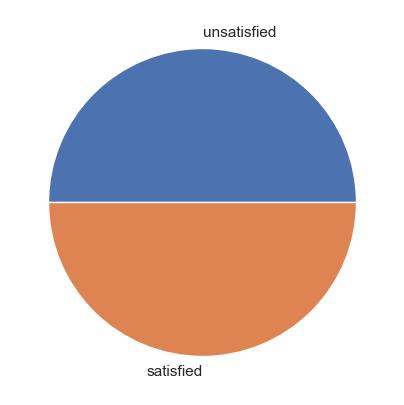

In [12]:
plt.figure(figsize=(5,5))
plt.pie(satisfaction_rate, labels=['unsatisfied','satisfied'])
plt.show()

In [13]:
train_data.corrwith(train_data['satisfaction']).abs().sort_values(ascending=False)

satisfaction                         1.000000
Online boarding                      0.504986
Inflight entertainment               0.400900
Seat comfort                         0.342294
On-board service                     0.326426
Leg room service                     0.324368
Cleanliness                          0.310338
Flight Distance                      0.298703
Inflight wifi service                0.277395
Baggage handling                     0.247965
Inflight service                     0.240584
Checkin service                      0.232359
Food and drink                       0.207854
Ease of Online booking               0.164662
Age                                  0.144302
Departure/Arrival time convenient    0.067638
Arrival Delay in Minutes             0.048650
Departure Delay in Minutes           0.042960
Gate location                        0.007169
id                                   0.002931
dtype: float64

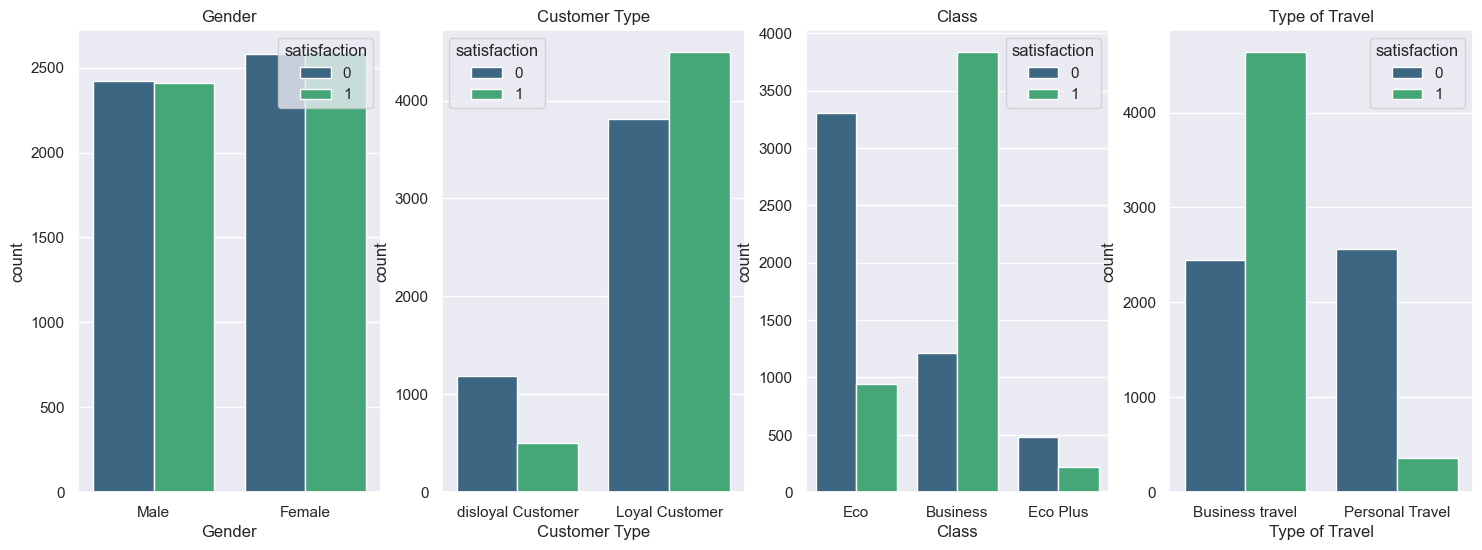

In [14]:
fig, axes = plt.subplots(1,4, figsize=(18,6))

sns.countplot(x='Gender', hue='satisfaction', palette='viridis', data=train_data, ax=axes[0])
axes[0].set_title("Gender")

sns.countplot(x='Customer Type', hue='satisfaction', palette='viridis', data=train_data, ax=axes[1])
axes[1].set_title("Customer Type")

sns.countplot(x='Class', hue='satisfaction', palette='viridis', data=train_data, ax=axes[2])
axes[2].set_title("Class")

sns.countplot(x='Type of Travel', hue='satisfaction', palette='viridis', data=train_data, ax=axes[3])
axes[3].set_title("Type of Travel")


plt.show()



In [15]:
# Drop columns which have the lowest correlation
train_data.drop([
    "id", "Gate location", "Departure Delay in Minutes", "Arrival Delay in Minutes", "Departure/Arrival time convenient"
], axis=1, inplace=True)

In [16]:
# convert nominal cat data to numeric
train_data = pd.get_dummies(train_data)
train_data.head()

,Age,Flight Distance,Inflight wifi service,Ease of Online booking,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,33,571,2,2,4,2,4,4,3,1,3,4,3,4,0,0,1,0,1,1,0,0,1,0
1,49,1431,4,4,3,5,4,5,5,5,5,3,5,3,1,1,0,1,0,1,0,1,0,0
2,43,867,1,4,4,4,3,1,1,1,1,1,1,2,0,1,0,1,0,1,0,0,1,0
3,27,1550,3,3,2,2,2,2,4,4,5,5,4,2,1,1,0,1,0,1,0,1,0,0
4,11,526,3,3,4,3,4,4,5,2,5,3,5,4,0,0,1,1,0,0,1,0,1,0


In [17]:
X = train_data.drop("satisfaction", axis=1)
y = train_data['satisfaction']

In [18]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Test Data
# Drop columns
test_data.drop([
    "id", "Gate location", "Departure Delay in Minutes", "Arrival Delay in Minutes", "Departure/Arrival time convenient"
], axis=1, inplace=True)

# convert nominal cat data to numeric
test_data = pd.get_dummies(test_data)
test_data.head()

scaler = StandardScaler()
test_data = scaler.fit_transform(test_data)

### ML
LogisticRegression

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1002
           1       0.89      0.85      0.87       998

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000

Accuracy: 0.876


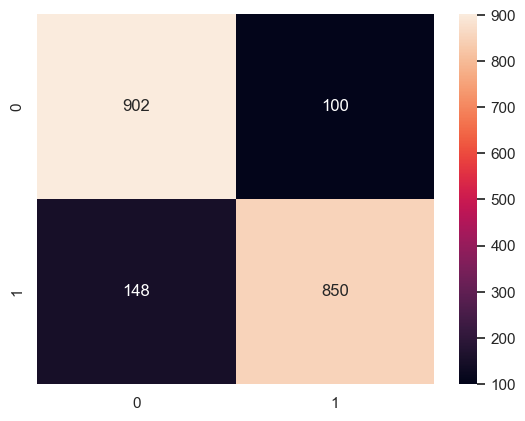

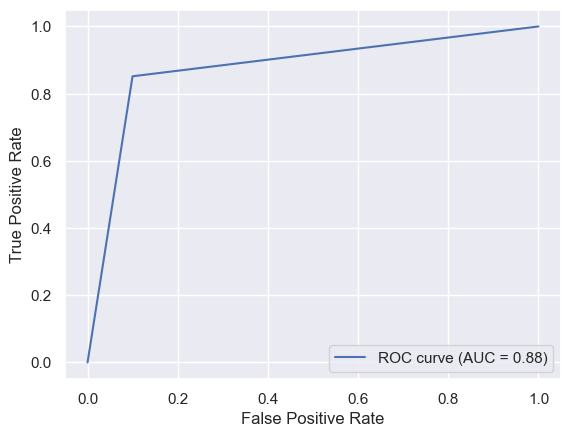

In [21]:
LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)

y_pred = LR_model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))

# confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True,fmt="g")
plt.show()

# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ROC curve')
display.plot()
plt.show()

Desicion Tree

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1002
           1       0.92      0.92      0.92       998

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000

Accuracy: 0.923


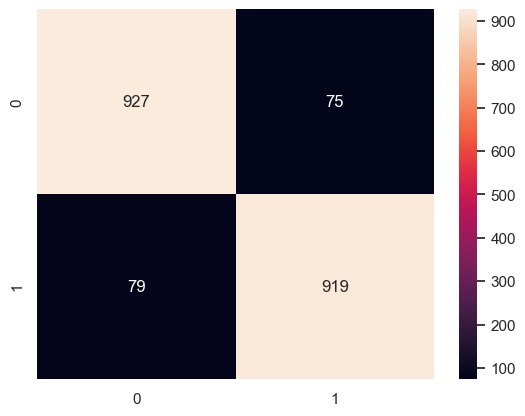

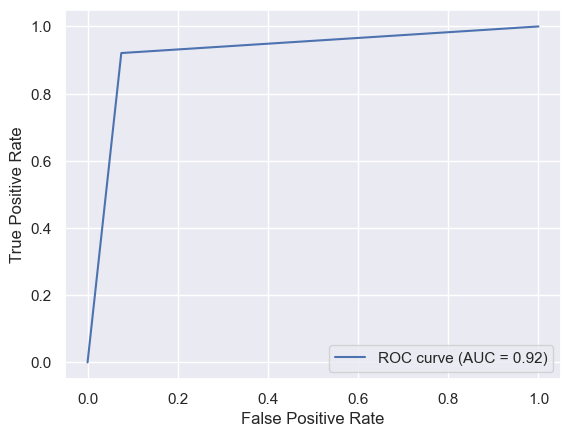

In [22]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))

# confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True,fmt="g")
plt.show()

# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ROC curve')
display.plot()
plt.show()

Random Forest

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1002
           1       0.96      0.94      0.95       998

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000

Accuracy: 0.9495


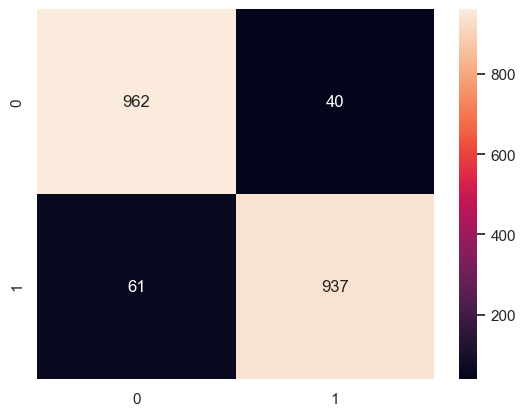

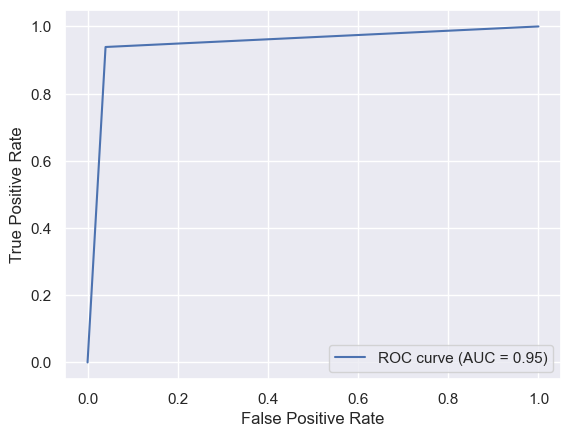

In [23]:
RF_model = RandomForestClassifier(n_estimators=9)
RF_model.fit(X_train, y_train)

# Modelni baholaymiz
y_pred = RF_model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))

## confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True,fmt="g")
plt.show()

## ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ROC curve')
display.plot()
plt.show()


In [24]:
submission = load_dataset("./","sample_submission.csv")
submission['satisfaction'] = RF_model.predict(test_data)
submission.to_csv('air_submission.csv', index=False)

In [25]:
submission = load_dataset("./","air_submission.csv")
submission

,id,satisfaction
0,1,0
1,2,1
2,3,1
3,4,1
4,5,0
...,...,...
3995,3996,1
3996,3997,0
3997,3998,0
3998,3999,0
